In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import *

In [2]:
df= pd.read_pickle("../data/clean_rows_df.pkl")  
df.head()

,VoltageCurve,CurrentCurve,spotName
TimeStamp,,,
2019-11-07 12:29:06,"[132, 744, 1299, 1663, 1894, 2002, 2068, 2110,...","[311, 1990, 3577, 4759, 5599, 6190, 6594, 6999...",60000_0_00
2019-11-07 12:29:26,"[136, 752, 1308, 1675, 1923, 2068, 2128, 2180,...","[301, 1961, 3470, 4527, 5432, 6066, 6489, 6911...",60000_0_00
2019-11-07 12:29:26,"[139, 757, 1292, 1655, 1885, 2042, 2099, 2099,...","[333, 2058, 3663, 4814, 5661, 6388, 6842, 7084...",60000_0_00
2019-11-07 12:29:30,"[133, 743, 1286, 1645, 1887, 2046, 2104, 2104,...","[307, 2031, 3632, 4802, 5695, 6434, 6865, 7142...",60000_0_00
2019-11-07 12:29:32,"[137, 755, 1313, 1683, 1906, 2043, 2147, 2189,...","[302, 1995, 3508, 4596, 5382, 5987, 6562, 6955...",60000_0_00


In [3]:
#Voltage_df=df.drop("CurrentCurve", axis=1)
#Current_df=df.drop("VoltageCurve", axis=1)

In [3]:
df.reset_index(inplace=True)
df.set_index(["spotName","TimeStamp"],inplace=True)

In [5]:
exploded_voltage=pd.DataFrame(df.VoltageCurve.tolist(), index= df.index)

In [6]:
#quali dati hanno la massima numerosità (624) di raccolte
#exploded_voltage[exploded_voltage[623].notna()].head()
#per selezionare la prima riga
#exploded_voltage.iloc[0]
#oppure
#exploded_voltage.loc[("60000_0_00","2019-11-07 12:29:06")]

# Analisi sui valori della tensione
Da grafico delle slide (da ricreare) si nota come molte curve abbiano un calo improvviso: andremo a cercare di identificare tali curve

<AxesSubplot:>

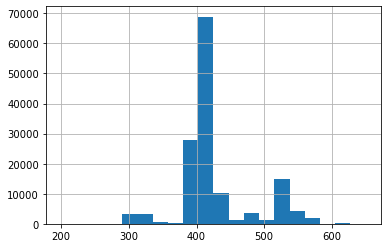

In [7]:
exploded_voltage.count(axis=1).hist(bins=20,range=(200,650))

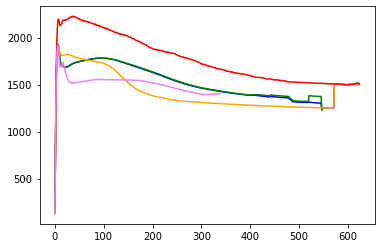

In [8]:
#plotto la curva media di tutti i valori
plot(exploded_voltage.mean(axis=0),"blue")
#plotto la curva media delle sole curve con meno di 500 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)<550].mean(axis=0),"green")
#plotto la curva media delle sole curve con più di 500 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)>550].mean(axis=0),"orange")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)>600].mean(axis=0),"red")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)<340].mean(axis=0),"violet")

# Approccio statistico di Anomaly Detection

## Analisi Strutturale: picchi e cali di tensione
Voglio identificare, attraverso un approccio statistico del differenziale, quelle curve che hanno avuto un picco (o un calo) improvviso della tensione, per cui risulta un anomalia strutturale della curva stessa.

Attraverso diversi tentativi e verifiche grafiche si è optato per un differenziale di quinto ordine.

In [9]:
#calcolo il differenziale di quinto ordine tra valori successivi 
voltage_lag5=exploded_voltage.diff(periods=5,axis=1)
#voltage_lag5.mean(axis=0).head(20)

DA RIVEDERE IL 4*x.std()

In [10]:
#creazione upper e lower limit con uso di mean e deviazion standard (mean +- 4*std)
upper_lag=voltage_lag5.apply(lambda x : x.mean()+4*x.std(),axis=0)
lower_lag=voltage_lag5.apply(lambda x : x.mean()-4*x.std(),axis=0)
#creazione upper e lower usando i quantili
upper_lag2=voltage_lag5.apply(lambda x : x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
lower_lag2=voltage_lag5.apply(lambda x : x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)

### Identificazione dei dati che mostrano un calo o un picco della tensione

In [11]:
#per poter verificare se i valori rientrano o meno nelle soglie stabilite devo trattare i Null:
#sostituisco i Null in voltage_lag5 con 0 
voltage_lag5=voltage_lag5.fillna(0)

#sostituisco i Null in upper_lag con 500
upper_lag=upper_lag.fillna(500)
#sostituisco i Null in lower_lag con -500
lower_lag=lower_lag.fillna(-500)

In [12]:
#creo la colonna voltage_drop per segnalare se nella curva c'è stato un calo di tensione
exploded_voltage["voltage_drop"]=voltage_lag5.apply(lambda x : any(x<lower_lag),axis=1)
#creo la colonna voltage_drop per segnalare se nella curva c'è stato un picco di tensione
exploded_voltage["voltage_spike"]=voltage_lag5.apply(lambda x : any(x>upper_lag),axis=1)

In [13]:
#creo voltage_drops con solo curve con cali di tensione
voltage_drops=exploded_voltage[exploded_voltage["voltage_drop"]==True]
voltage_drops=voltage_drops.drop(["voltage_drop","voltage_spike"],axis=1)

In [14]:
##creo voltage_spikes con solo curve con picchi di tensione
voltage_spikes=exploded_voltage[exploded_voltage["voltage_spike"]==True]
voltage_spikes=voltage_spikes.drop(["voltage_drop","voltage_spike"],axis=1)

Esempio di detection di un calo anomalo della tensione

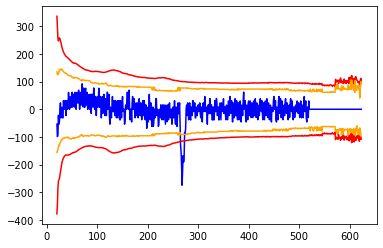

In [15]:
# plot dei differenziali e relativi range di ammissibilità
plt.plot(upper_lag[20:],"red")
plt.plot(upper_lag2[20:],"orange")
plot(voltage_lag5[any(voltage_lag5<lower_lag,axis=1)].iloc[1][20:],"blue")
plt.plot(lower_lag2[20:],"orange")
plt.plot(lower_lag[20:],"red")

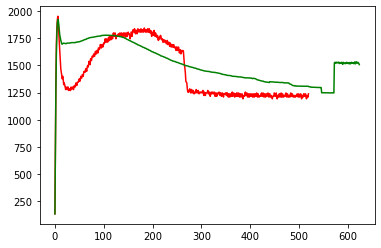

In [16]:
#curva con picco in rosso
plot(voltage_drops.iloc[1],"red")
#curva media tra tutti i dati in verde
plt.plot(exploded_voltage.iloc[: , :624].median(axis=0),"green")

Esempio di detection di un picco anomalo della tensione

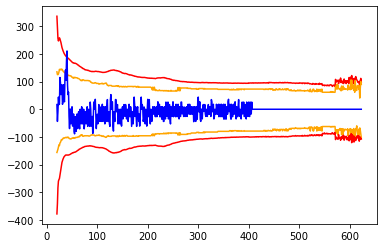

In [17]:
plt.plot(upper_lag[20:],"red")
plt.plot(upper_lag2[20:],"orange")
plot(voltage_lag5[any(voltage_lag5>upper_lag,axis=1)].iloc[1][20:],"blue")
plt.plot(lower_lag2[20:],"orange")
plt.plot(lower_lag[20:],"red")

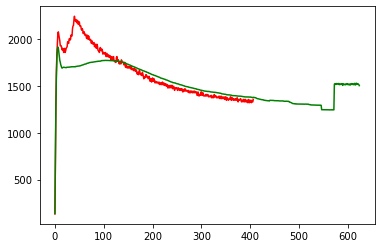

In [18]:
#curva con picco in rosso
plot(voltage_spikes.iloc[1],"red")
#curva media tra tutti i dati in verde
#plt.plot(voltage_no_drops.median(axis=0),"blue")
plt.plot(exploded_voltage.iloc[: , :624].median(axis=0),"green")

Esempio di curva che presenta sia un picco che un calo anomalo della tensione

In [19]:
#creo both_anomalies, dataframe in cui le curve hanno sia un picco che un calo in tensione
both_anomalies=exploded_voltage[(exploded_voltage["voltage_drop"]==True) & (exploded_voltage["voltage_spike"]==True)]
both_anomalies=both_anomalies.drop(["voltage_drop","voltage_spike"],axis=1)
len(both_anomalies)

713

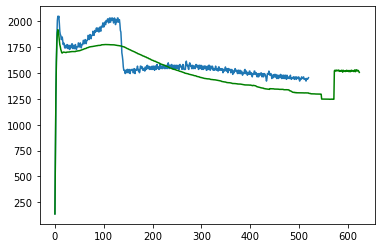

In [20]:
plot(both_anomalies.iloc[65])
plt.plot(exploded_voltage.iloc[: , :624].median(axis=0),"green")

In [21]:
#aggiungo la colonna voltage_drop e voltage_spike al df originale
df=df.join(exploded_voltage[["voltage_drop","voltage_spike"]],how="left")

In [22]:
df.head()

VoltageCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [139, 752, 1329, 1687, 1897, 2037, 2098, 2107,...   
           2019-09-17 17:56:07  [134, 755, 1309, 1661, 1888, 2056, 2140, 2140,...   
           2019-09-17 18:05:02  [134, 758, 1298, 1652, 1897, 2065, 2124, 2124,...   
           2019-09-17 18:42:46  [138, 767, 1328, 1682, 1906, 2061, 2139, 2148,...   
           2019-09-17 18:59:36  [130, 745, 1300, 1646, 1854, 2028, 2114, 2114,...   

                                                                     CurrentCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [302, 1999, 3574, 4694, 5512, 6148, 6542, 6815...   
           2019-09-17 17:56:07  [303, 2002, 3549, 4702, 5551, 6340, 6886, 7189...   
           2019-09-17 18:05:02  [305, 2017, 3607, 4738, 5656, 6389, 6848, 7154...   
           2019-09-17 18:42:46  [333, 2033, 3641, 4795, 5614, 6312, 6767, 7040...   
           2019-09-17 18:59:36  [302, 1996, 3569, 4719, 5536, 6262, 6837, 7109...   

                                voltage_drop  voltage_spike  
spotName   TimeStamp                                         
60000_0_00 2019-09-17 17:56:02         False          False  
           2019-09-17 17:56:07         False          False  
           2019-09-17 18:05:02         False          False  
           2019-09-17 18:42:46         False          False  
           2019-09-17 18:59:36         False          False

## Anomaly detection per singoli punti
Non conosciamo la distribuzione che i dati assumono nei vari istanti temporali (anche se data la numerosità potremmo assumere una distribuzione normale). Definiamo gli outlier come:
-   The data points which fall below mean-3*(sigma) or above mean+3*(sigma) [adatta a norm]
-   The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR [adatta per dist asimettriche]

In [23]:
no_spikes=exploded_voltage[(exploded_voltage["voltage_drop"]==False) & (exploded_voltage["voltage_spike"]==False)]


In [24]:
no_spikes=no_spikes.drop(["voltage_drop","voltage_spike"],axis=1)
print(len(no_spikes)/len(exploded_voltage))
len(no_spikes)

0.798209463260943


113499

Poichè le curve con picchi o cali anomali della tensione anomali rappresentano circa il 20% delle curve totali andrò a definire le curve di ammissione con 1.5*deviazione standard che rappresenta circa l'87% della distribuzione di una normale. Approccio quindi safe rispetto alle anomalie già trovate

![gatto](../curva-gaussiana-normale-standardizzata.gif)

In [25]:
#creazione upper e lower limit come per Normale (mean +- 2*std:al 95%,mean +- 3*std:al 99% )
upper_limit=exploded_voltage.drop(["voltage_drop","voltage_spike"],axis=1).apply(lambda x : x.mean()+1.5*x.std(),axis=0)
lower_limit=exploded_voltage.drop(["voltage_drop","voltage_spike"],axis=1).apply(lambda x : x.mean()-1.5*x.std(),axis=0)

Stesso discorso con i limiti percentili: andrò a considerare valori fuori norma quelli oltre il 94° percentile (o inferiore al 6° percentile)

In [26]:
#creazione upper e lower usando i quantili
#upper_limit2=no_spikes.apply(lambda x : x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
#lower_limit2=no_spikes.apply(lambda x : x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
upper_limit2=no_spikes.apply(lambda x : x.quantile(0.90),axis=0)
lower_limit2=no_spikes.apply(lambda x : x.quantile(0.1),axis=0)

In [27]:
#sostituisco i valori na dei range con i quantili con valori abbastanza ampi da contenere gli eventuali notNA
upper_limit2=upper_limit2.fillna(1650)
lower_limit2=lower_limit2.fillna(1350)

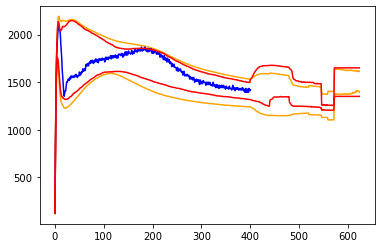

In [28]:
#plottiamo i limiti per vedere come si comportano (in arancio limiti con la std, in rosso con i percentili)
#ex particolari: 590
plot(upper_limit,"orange")
plot(lower_limit,"orange")
plot(exploded_voltage.drop(["voltage_drop","voltage_spike"],axis=1).iloc[30],"blue")
plot(upper_limit2,"red")
plot(lower_limit2,"red")

Si nota che gli itervalli costruiti tramite percentili sono leggeremente traslati verso l'alto. Decidiamo di considerare i percentili per la definizione degli outlier poichè la mediana è una misura più robusta alla presenza di outlier. 

In [29]:
media=exploded_voltage.mean()
no_nulls=exploded_voltage.fillna(media)

In [30]:
no_nulls.drop(["voltage_drop","voltage_spike"],axis=1,inplace=True)

In [31]:
#verifico se i valori di ogni curva sono all'interno dei limiti precedentemente definiti
single_outliers=no_nulls.apply(lambda x : x.between(lower_limit2,upper_limit2) ,axis=1)

In [32]:
single_outliers.iloc[0].value_counts()

False    360
True     264
Name: (60000_0_00, 2019-11-07 12:29:06), dtype: int64

In [33]:
#conta del numero di False, quindi outliers, presenti in ogni curva costruendo la colonna n_voltage_outliers
single_outliers["n_voltage_outliers"]=single_outliers.apply(lambda x : len(x)-x.sum() ,axis=1)
single_outliers

0     1     2     3      4      5      6  \
spotName   TimeStamp                                                          
60000_0_00 2019-11-07 12:29:06  True  True  True  True   True   True   True   
           2019-11-07 12:29:26  True  True  True  True  False  False  False   
           2019-11-07 12:29:26  True  True  True  True   True  False   True   
           2019-11-07 12:29:30  True  True  True  True   True  False  False   
           2019-11-07 12:29:32  True  True  True  True  False  False  False   
...                              ...   ...   ...   ...    ...    ...    ...   
60001_0_00 2020-05-28 15:00:04  True  True  True  True   True  False   True   
60021_0_00 2020-05-28 15:00:04  True  True  True  True   True   True   True   
60023_0_00 2020-05-28 15:00:17  True  True  True  True   True   True  False   
60025_0_00 2020-05-28 15:00:17  True  True  True  True   True   True   True   
60027_0_00 2020-05-28 15:00:17  True  True  True  True   True   True   True   

                                    7      8      9  ...   615   616   617  \
spotName   TimeStamp                                 ...                     
60000_0_00 2019-11-07 12:29:06   True   True   True  ...  True  True  True   
           2019-11-07 12:29:26  False  False  False  ...  True  True  True   
           2019-11-07 12:29:26   True   True   True  ...  True  True  True   
           2019-11-07 12:29:30   True  False   True  ...  True  True  True   
           2019-11-07 12:29:32  False  False  False  ...  True  True  True   
...                               ...    ...    ...  ...   ...   ...   ...   
60001_0_00 2020-05-28 15:00:04   True   True   True  ...  True  True  True   
60021_0_00 2020-05-28 15:00:04  False  False  False  ...  True  True  True   
60023_0_00 2020-05-28 15:00:17  False  False  False  ...  True  True  True   
60025_0_00 2020-05-28 15:00:17   True   True   True  ...  True  True  True   
60027_0_00 2020-05-28 15:00:17   True   True   True  ...  True  True  True   

                                 618   619   620   621   622   623  \
spotName   TimeStamp                                                 
60000_0_00 2019-11-07 12:29:06  True  True  True  True  True  True   
           2019-11-07 12:29:26  True  True  True  True  True  True   
           2019-11-07 12:29:26  True  True  True  True  True  True   
           2019-11-07 12:29:30  True  True  True  True  True  True   
           2019-11-07 12:29:32  True  True  True  True  True  True   
...                              ...   ...   ...   ...   ...   ...   
60001_0_00 2020-05-28 15:00:04  True  True  True  True  True  True   
60021_0_00 2020-05-28 15:00:04  True  True  True  True  True  True   
60023_0_00 2020-05-28 15:00:17  True  True  True  True  True  True   
60025_0_00 2020-05-28 15:00:17  True  True  True  True  True  True   
60027_0_00 2020-05-28 15:00:17  True  True  True  True  True  True   

                                n_voltage_outliers  
spotName   TimeStamp                                
60000_0_00 2019-11-07 12:29:06                 360  
           2019-11-07 12:29:26                  45  
           2019-11-07 12:29:26                  21  
           2019-11-07 12:29:30                  29  
           2019-11-07 12:29:32                  37  
...                                            ...  
60001_0_00 2020-05-28 15:00:04                  83  
60021_0_00 2020-05-28 15:00:04                  36  
60023_0_00 2020-05-28 15:00:17                  42  
60025_0_00 2020-05-28 15:00:17                   1  
60027_0_00 2020-05-28 15:00:17                   4  

[142192 rows x 625 columns]

In [34]:
len(single_outliers)

142192

In [35]:
#aggiungo la colonna n_voltage_outliers al df originale
df=df.join(single_outliers["n_voltage_outliers"],how="left")
df

VoltageCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [139, 752, 1329, 1687, 1897, 2037, 2098, 2107,...   
           2019-09-17 17:56:07  [134, 755, 1309, 1661, 1888, 2056, 2140, 2140,...   
           2019-09-17 18:05:02  [134, 758, 1298, 1652, 1897, 2065, 2124, 2124,...   
           2019-09-17 18:42:46  [138, 767, 1328, 1682, 1906, 2061, 2139, 2148,...   
           2019-09-17 18:59:36  [130, 745, 1300, 1646, 1854, 2028, 2114, 2114,...   
...                                                                           ...   
60185_0_00 2020-05-06 14:06:47  [145, 809, 1349, 1648, 1816, 1860, 1808, 1743,...   
           2020-05-06 14:18:28  [145, 816, 1378, 1684, 1794, 1860, 1838, 1736,...   
           2020-05-27 09:15:45  [153, 813, 1356, 1657, 1825, 1869, 1818, 1759,...   
           2020-05-27 09:27:57  [149, 813, 1377, 1662, 1798, 1820, 1820, 1755,...   
           2020-05-27 10:18:20  [148, 807, 1356, 1667, 1845, 1890, 1815, 1756,...   

                                                                     CurrentCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [302, 1999, 3574, 4694, 5512, 6148, 6542, 6815...   
           2019-09-17 17:56:07  [303, 2002, 3549, 4702, 5551, 6340, 6886, 7189...   
           2019-09-17 18:05:02  [305, 2017, 3607, 4738, 5656, 6389, 6848, 7154...   
           2019-09-17 18:42:46  [333, 2033, 3641, 4795, 5614, 6312, 6767, 7040...   
           2019-09-17 18:59:36  [302, 1996, 3569, 4719, 5536, 6262, 6837, 7109...   
...                                                                           ...   
60185_0_00 2020-05-06 14:06:47  [354, 2200, 4081, 5500, 6565, 7239, 7594, 7842...   
           2020-05-06 14:18:28  [337, 2262, 4288, 5773, 6786, 7563, 8069, 8205...   
           2020-05-27 09:15:45  [337, 2193, 4116, 5499, 6512, 7220, 7490, 7726...   
           2020-05-27 09:27:57  [333, 2265, 4197, 5630, 6562, 7162, 7662, 7928...   
           2020-05-27 10:18:20  [317, 2188, 4059, 5471, 6565, 7200, 7518, 7730...   

                                voltage_drop  voltage_spike  \
spotName   TimeStamp                                          
60000_0_00 2019-09-17 17:56:02         False          False   
           2019-09-17 17:56:07         False          False   
           2019-09-17 18:05:02         False          False   
           2019-09-17 18:42:46         False          False   
           2019-09-17 18:59:36         False          False   
...                                      ...            ...   
60185_0_00 2020-05-06 14:06:47         False          False   
           2020-05-06 14:18:28         False          False   
           2020-05-27 09:15:45         False          False   
           2020-05-27 09:27:57         False          False   
           2020-05-27 10:18:20         False          False   

                                n_voltage_outliers  
spotName   TimeStamp                                
60000_0_00 2019-09-17 17:56:02                  27  
           2019-09-17 17:56:07                  29  
           2019-09-17 18:05:02                   9  
           2019-09-17 18:42:46                  30  
           2019-09-17 18:59:36                  31  
...                                            ...  
60185_0_00 2020-05-06 14:06:47                 198  
           2020-05-06 14:18:28                  27  
           2020-05-27 09:15:45                 143  
           2020-05-27 09:27:57                  13  
           2020-05-27 10:18:20                 173  

[144028 rows x 5 columns]

Creo colonna %volt_anomalies che mi indica la percentuale di punti anomali sul numero di punti della curva

In [36]:
df["%volt_anomalies"]=df.apply(lambda x: x.n_voltage_outliers/len(x.VoltageCurve)*100,axis=1)

In [38]:
df.to_pickle("../data/with_stat_anomalies.pkl")

Creo dataset con le curve di riferiment utilizzate:
- curva media
- intervallo per outlier (con quantili)

In [34]:
reference_curves=pd.concat([media[:624],upper_limit2,lower_limit2],keys=['media', 'upper_limit',"lower_limit"],axis=1)
reference_curves

,media,upper_limit,lower_limit
0,133.533012,144.0,126.0
1,754.758250,796.0,732.0
2,1288.253291,1345.0,1248.0
3,1610.341199,1683.0,1544.0
4,1794.434930,1896.0,1689.0
...,...,...,...
619,1510.000000,1650.0,1350.0
620,1507.859649,1650.0,1350.0
621,1513.321429,1650.0,1350.0
622,1512.890909,1650.0,1350.0


In [35]:
reference_curves.to_pickle("../data/reference_volt_curves.pkl")

# Analisi sui valori della corrente
Da grafico delle slide (da ricreare) si nota come molte curve abbiano un calo improvviso: andremo a cercare di identificare tali curve

In [4]:
exploded_current=pd.DataFrame(df.CurrentCurve.tolist(), index= df.index)

<AxesSubplot:>

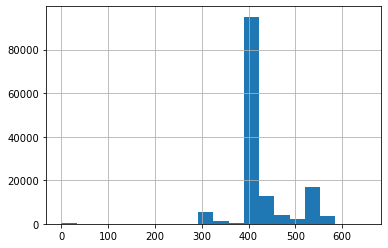

In [5]:
exploded_current.count(axis=1).hist(bins=20,range=(0,650))

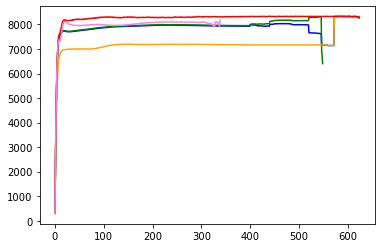

In [6]:
#plotto la curva media di tutti i valori
plot(exploded_current.mean(axis=0),"blue")
#plotto la curva media delle sole curve con meno di 500 rilevazioni
plot(exploded_current[exploded_current.count(axis=1)<550].mean(axis=0),"green")
#plotto la curva media delle sole curve con più di 500 rilevazioni
plot(exploded_current[exploded_current.count(axis=1)>550].mean(axis=0),"orange")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_current[exploded_current.count(axis=1)>600].mean(axis=0),"red")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_current[exploded_current.count(axis=1)<340].mean(axis=0),"violet")

I valori di corrente che più sembrano discostarsi sono quelli con dimensionalità maggiore di 550

## Anomaly detection per singoli punti
Non conosciamo la distribuzione che i dati assumono nei vari istanti temporali (anche se data la numerosità potremmo assumere una distribuzione normale). Definiamo gli outlier come:
-   The data points which fall below mean-3*(sigma) or above mean+3*(sigma) [adatta a norm]
-   The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR [adatta per dist asimettriche]

In [8]:
#creazione upper e lower limit come per Normale (mean +- 2*std:al 95%,mean +- 3*std:al 99% )
upper_limit=exploded_current.apply(lambda x : x.mean()+1.5*x.std(),axis=0)
lower_limit=exploded_current.apply(lambda x : x.mean()-1.5*x.std(),axis=0)

In [18]:
#creazione upper e lower usando i quantili
upper_limit2=exploded_current.apply(lambda x : x.quantile(0.75)+1*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
lower_limit2=exploded_current.apply(lambda x : x.quantile(0.25)-1*(x.quantile(0.75)-x.quantile(0.25)),axis=0)

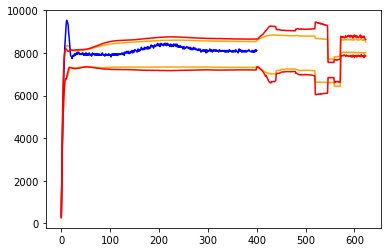

In [19]:
#plottiamo i limiti per vedere come si comportano (in arancio limiti con la std, in rosso con i percentili)
#ex particolari: 590
plot(upper_limit,"orange")
plot(lower_limit,"orange")
plot(exploded_current.iloc[30],"blue")
#plot(upper_limit2,"red")
#plot(lower_limit2,"red")

In [20]:
media=exploded_current.mean()
no_nulls=exploded_current.fillna(media)

In [23]:
#verifico se i valori di ogni curva sono all'interno dei limiti precedentemente definiti
single_outliers=no_nulls.apply(lambda x : x.between(lower_limit,upper_limit) ,axis=1)

In [24]:
#conta del numero di False, quindi outliers, presenti in ogni curva costruendo la colonna n_voltage_outliers
single_outliers["n_current_outliers"]=single_outliers.apply(lambda x : len(x)-x.sum() ,axis=1)
single_outliers

0      1      2      3      4     5     6  \
spotName   TimeStamp                                                           
60000_0_00 2019-11-07 12:29:06  True   True   True   True   True  True  True   
           2019-11-07 12:29:26  True   True  False  False   True  True  True   
           2019-11-07 12:29:26  True   True   True   True   True  True  True   
           2019-11-07 12:29:30  True   True   True   True   True  True  True   
           2019-11-07 12:29:32  True   True   True   True  False  True  True   
...                              ...    ...    ...    ...    ...   ...   ...   
60001_0_00 2020-05-28 15:00:04  True   True   True   True   True  True  True   
60021_0_00 2020-05-28 15:00:04  True   True   True   True   True  True  True   
60023_0_00 2020-05-28 15:00:17  True   True   True   True   True  True  True   
60025_0_00 2020-05-28 15:00:17  True  False   True   True   True  True  True   
60027_0_00 2020-05-28 15:00:17  True   True   True   True   True  True  True   

                                   7     8     9  ...   615   616   617   618  \
spotName   TimeStamp                              ...                           
60000_0_00 2019-11-07 12:29:06  True  True  True  ...  True  True  True  True   
           2019-11-07 12:29:26  True  True  True  ...  True  True  True  True   
           2019-11-07 12:29:26  True  True  True  ...  True  True  True  True   
           2019-11-07 12:29:30  True  True  True  ...  True  True  True  True   
           2019-11-07 12:29:32  True  True  True  ...  True  True  True  True   
...                              ...   ...   ...  ...   ...   ...   ...   ...   
60001_0_00 2020-05-28 15:00:04  True  True  True  ...  True  True  True  True   
60021_0_00 2020-05-28 15:00:04  True  True  True  ...  True  True  True  True   
60023_0_00 2020-05-28 15:00:17  True  True  True  ...  True  True  True  True   
60025_0_00 2020-05-28 15:00:17  True  True  True  ...  True  True  True  True   
60027_0_00 2020-05-28 15:00:17  True  True  True  ...  True  True  True  True   

                                 619   620   621   622   623  \
spotName   TimeStamp                                           
60000_0_00 2019-11-07 12:29:06  True  True  True  True  True   
           2019-11-07 12:29:26  True  True  True  True  True   
           2019-11-07 12:29:26  True  True  True  True  True   
           2019-11-07 12:29:30  True  True  True  True  True   
           2019-11-07 12:29:32  True  True  True  True  True   
...                              ...   ...   ...   ...   ...   
60001_0_00 2020-05-28 15:00:04  True  True  True  True  True   
60021_0_00 2020-05-28 15:00:04  True  True  True  True  True   
60023_0_00 2020-05-28 15:00:17  True  True  True  True  True   
60025_0_00 2020-05-28 15:00:17  True  True  True  True  True   
60027_0_00 2020-05-28 15:00:17  True  True  True  True  True   

                                n_current_outliers  
spotName   TimeStamp                                
60000_0_00 2019-11-07 12:29:06                  28  
           2019-11-07 12:29:26                  49  
           2019-11-07 12:29:26                   6  
           2019-11-07 12:29:30                  17  
           2019-11-07 12:29:32                  25  
...                                            ...  
60001_0_00 2020-05-28 15:00:04                   2  
60021_0_00 2020-05-28 15:00:04                   0  
60023_0_00 2020-05-28 15:00:17                   0  
60025_0_00 2020-05-28 15:00:17                   1  
60027_0_00 2020-05-28 15:00:17                   3  

[142192 rows x 625 columns]

In [25]:
#aggiungo la colonna n_voltage_outliers al df originale
df=df.join(single_outliers["n_current_outliers"],how="left")
df.head()

VoltageCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [139, 752, 1329, 1687, 1897, 2037, 2098, 2107,...   
           2019-09-17 17:56:07  [134, 755, 1309, 1661, 1888, 2056, 2140, 2140,...   
           2019-09-17 18:05:02  [134, 758, 1298, 1652, 1897, 2065, 2124, 2124,...   
           2019-09-17 18:42:46  [138, 767, 1328, 1682, 1906, 2061, 2139, 2148,...   
           2019-09-17 18:59:36  [130, 745, 1300, 1646, 1854, 2028, 2114, 2114,...   

                                                                     CurrentCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [302, 1999, 3574, 4694, 5512, 6148, 6542, 6815...   
           2019-09-17 17:56:07  [303, 2002, 3549, 4702, 5551, 6340, 6886, 7189...   
           2019-09-17 18:05:02  [305, 2017, 3607, 4738, 5656, 6389, 6848, 7154...   
           2019-09-17 18:42:46  [333, 2033, 3641, 4795, 5614, 6312, 6767, 7040...   
           2019-09-17 18:59:36  [302, 1996, 3569, 4719, 5536, 6262, 6837, 7109...   

                                n_current_outliers  
spotName   TimeStamp                                
60000_0_00 2019-09-17 17:56:02                  20  
           2019-09-17 17:56:07                   9  
           2019-09-17 18:05:02                   0  
           2019-09-17 18:42:46                   5  
           2019-09-17 18:59:36                  13

Creo colonna %volt_anomalies che mi indica la percentuale di punti anomali sul numero di punti della curva

In [29]:
df["%current_anomalies"]=df.apply(lambda x: x.n_current_outliers/len(x.CurrentCurve)*100,axis=1)

In [30]:
df.head()

VoltageCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [139, 752, 1329, 1687, 1897, 2037, 2098, 2107,...   
           2019-09-17 17:56:07  [134, 755, 1309, 1661, 1888, 2056, 2140, 2140,...   
           2019-09-17 18:05:02  [134, 758, 1298, 1652, 1897, 2065, 2124, 2124,...   
           2019-09-17 18:42:46  [138, 767, 1328, 1682, 1906, 2061, 2139, 2148,...   
           2019-09-17 18:59:36  [130, 745, 1300, 1646, 1854, 2028, 2114, 2114,...   

                                                                     CurrentCurve  \
spotName   TimeStamp                                                                
60000_0_00 2019-09-17 17:56:02  [302, 1999, 3574, 4694, 5512, 6148, 6542, 6815...   
           2019-09-17 17:56:07  [303, 2002, 3549, 4702, 5551, 6340, 6886, 7189...   
           2019-09-17 18:05:02  [305, 2017, 3607, 4738, 5656, 6389, 6848, 7154...   
           2019-09-17 18:42:46  [333, 2033, 3641, 4795, 5614, 6312, 6767, 7040...   
           2019-09-17 18:59:36  [302, 1996, 3569, 4719, 5536, 6262, 6837, 7109...   

                                n_current_outliers  %current_anomalies  
spotName   TimeStamp                                                    
60000_0_00 2019-09-17 17:56:02                  20            4.784689  
           2019-09-17 17:56:07                   9            2.153110  
           2019-09-17 18:05:02                   0            0.000000  
           2019-09-17 18:42:46                   5            1.196172  
           2019-09-17 18:59:36                  13            3.117506

In [ ]:
df.to_pickle("../data/with_stat_anomalies.pkl")

Creo dataset con le curve di riferiment utilizzate:
- curva media
- intervallo per outlier

In [31]:
reference_curves=pd.concat([media[:624],upper_limit,lower_limit],keys=['media', 'upper_limit',"lower_limit"],axis=1)
reference_curves

,media,upper_limit,lower_limit
0,307.059835,354.517130,259.602539
1,2055.203634,2208.043074,1902.364194
2,3787.606977,4102.744228,3472.469726
3,5027.751946,5466.574478,4588.929415
4,5918.775205,6450.914112,5386.636297
...,...,...,...
619,8306.650000,8635.614302,7977.685698
620,8302.385965,8605.125787,7999.646143
621,8318.660714,8626.175717,8011.145711
622,8315.090909,8629.762335,8000.419484


In [32]:
reference_curves.to_pickle("../data/reference_current_curves.pkl")